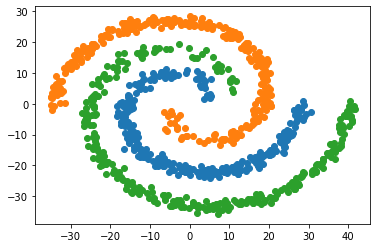

In [1]:
# Create the dataset of three spirals by calculating the angle of revolution and using the corresponding formula

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

N = 300 # number of data points per spiral 
theta = np.sqrt(np.random.rand(N))*2*pi #generate array of N length for theta 

#generate arrays for the spirals 
r_a = 4*theta + pi 
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -5*theta - pi 
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

r_c = 5*theta + 3*pi
data_c = np.array([np.cos(theta)*r_c, np.sin(theta)*r_c]).T
x_c = data_c + np.random.randn(N,2)

#appends each spiral with its corresponding output number
res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)
res_c = np.append(x_c, np.full((N,1), 2.0), axis=1)

#creates single array with all values and outputs
res = np.append(res_a, res_b, axis=0)
res2 = np.append(res, res_c, axis=0)
np.random.shuffle(res2)

#save to csv file
np.savetxt("result.csv", res2, delimiter=",", comments="", fmt='%.5f')

#plots the spirals
plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.scatter(x_c[:,0],x_c[:,1])
plt.show()

In [2]:
# Load dataset and split it into training and test split

import pandas as pd 
import torch 
from sklearn.model_selection import train_test_split

#load the data set 
data = pd.read_csv('result.csv', header=None, names=['x','y','output'])

# Split into numpy arrays with features and labels
input = data[['x', 'y']].to_numpy()
output = data[['output']].to_numpy().flatten()

# Split into train and test
in_train, in_test, out_train, out_test = train_test_split(input, output, test_size=0.2, random_state=15)

# Convert to torch tensors
in_train = torch.from_numpy(in_train).type(torch.float32)
in_test = torch.from_numpy(in_test).type(torch.float32)
out_train = torch.from_numpy(out_train).type(torch.LongTensor)
out_test = torch.from_numpy(out_test).type(torch.LongTensor)

In [3]:
# Defining the model with one hidden layer, with softmax on the hidden layer and on the ouptut 

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 32, bias=True) # hidden layer
        self.fc2 = torch.nn.Linear(32, 3, bias=True) # output layer
        self.softmax = torch.nn.Softmax(dim=1) 
    def forward(self, x):
        x = torch.nn.Softmax(dim=1)(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
# Instantiate model and adam optimiser, using cross entropy loss function

model = Model()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
print(model)

Model(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [5]:
# Conduct training and testing with 1000 epochs, print result after every 100 epochs 

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1001):
    # Zero gradients
    optimiser.zero_grad()
    # Forward pass
    out_pred = model(in_train)
    # Calculate loss
    loss = loss_fn(out_pred, out_train)   
    # Backward pass
    loss.backward()
    # Update weights
    optimiser.step()
    # Calculate metrics
    train_acc = torch.sum(torch.argmax(out_pred, dim=1) == out_train) / out_train.shape[0]
    with torch.no_grad():
        out_pred_test = model(in_test)
        test_loss = loss_fn(out_pred_test, out_test)
        test_acc = torch.sum(torch.argmax(out_pred_test, dim=1) == out_test) / out_test.shape[0]
    # Log metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc)
    if epoch % 100 == 0:
        # Print to console
        print("Epoch {}:\tTrain loss={:.4f}  \tTrain acc={:.2f}  \tTest loss={:.4f}  \tTest acc={:.2f}".format(
            epoch, loss.item(), train_acc*100, test_loss.item(), test_acc*100))

Epoch 0:	Train loss=1.1035  	Train acc=29.31  	Test loss=1.1011  	Test acc=28.33
Epoch 100:	Train loss=0.9056  	Train acc=76.94  	Test loss=0.9030  	Test acc=77.78
Epoch 200:	Train loss=0.7706  	Train acc=89.17  	Test loss=0.7726  	Test acc=88.89
Epoch 300:	Train loss=0.6763  	Train acc=99.03  	Test loss=0.6765  	Test acc=97.78
Epoch 400:	Train loss=0.6116  	Train acc=99.17  	Test loss=0.6202  	Test acc=98.33
Epoch 500:	Train loss=0.5846  	Train acc=99.44  	Test loss=0.5906  	Test acc=98.33
Epoch 600:	Train loss=0.5730  	Train acc=99.58  	Test loss=0.5796  	Test acc=98.33
Epoch 700:	Train loss=0.5671  	Train acc=99.58  	Test loss=0.5740  	Test acc=98.33
Epoch 800:	Train loss=0.5635  	Train acc=99.72  	Test loss=0.5706  	Test acc=98.33
Epoch 900:	Train loss=0.5611  	Train acc=99.72  	Test loss=0.5684  	Test acc=98.33
Epoch 1000:	Train loss=0.5595  	Train acc=99.72  	Test loss=0.5668  	Test acc=98.33


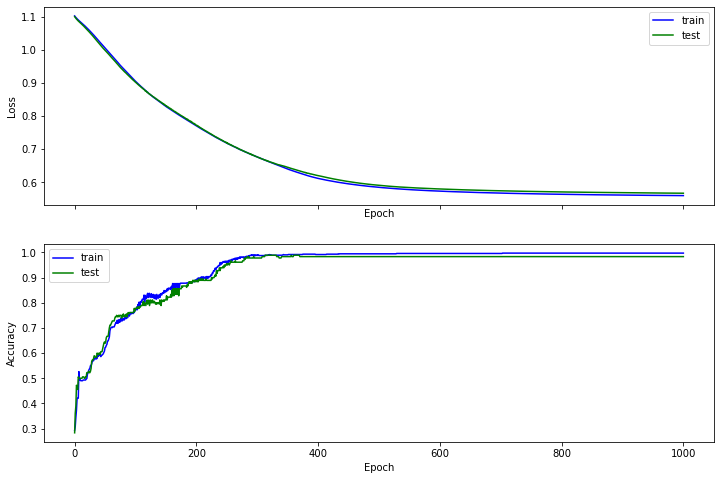

In [6]:
# Plotting the loss and accuracy with respect to the number of epochs to view convergence 

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
ax1.plot(train_losses, color='b', label='train')
ax1.plot(test_losses, color='g', label='test')
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax2.plot(train_accuracies, color='b', label='train')
ax2.plot(test_accuracies, color='g', label='test')
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()

In [10]:
# Compute confusion matrix to view number of FN or FP

from sklearn.metrics import confusion_matrix

# Compute final prediction for test set
with torch.no_grad():
    out_pred_probs_test = model(in_test).numpy()
    
# Convert prediction probabilities to classes 
out_pred_classes_test = np.argmax(out_pred_probs_test, axis=1)

confusion_matrix(out_test, out_pred_classes_test)

array([[61,  0,  0],
       [ 0, 58,  0],
       [ 3,  0, 58]], dtype=int64)

In [79]:
# Compute summary of accuracy, precision and recall metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Compute the accuracy.
print("Accuracy = {:.2f}".format(accuracy_score(out_test, out_pred_classes_test)))

# Compute the precision (affected by class imbalance)
print("Precision (global) = {:.2f}".format(precision_score(out_test, out_pred_classes_test, average='micro')))
# Compute the recall (affected by class imbalance)
print("Recall (global) = {:.2f}".format(recall_score(out_test, out_pred_classes_test, average='micro')))

# Compute the precision (removed effect of class imbalance)
print("Precision (mean of class precisions) = {:.2f}".format(precision_score(out_test, out_pred_classes_test, average='macro')))
# Compute the recall (removed effect of class imbalance)
print("Recall (mean of class recalls) = {:.2f}".format(recall_score(out_test, out_pred_classes_test, average='macro')))

Accuracy = 0.98
Precision (global) = 0.98
Recall (global) = 0.98
Precision (mean of class precisions) = 0.98
Recall (mean of class recalls) = 0.98


In [7]:
# Build initial SVM without tuned hyperparamaters 

from sklearn.svm import SVC

# Build the classifier
svm = SVC(C=0.1, kernel='rbf', gamma=10)

# Fit to the data:
svm.fit(in_train, out_train)

print('Model test accuracy: {:.2f}%'.format(svm.score(in_test, out_test)*100))

Model test accuracy: 32.22%


In [ ]:
# Create a grid search to find ideal hyperparameters 

from sklearn.model_selection import GridSearchCV

# Set up a dictionary of parameters to define our grid to search over
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# We will create an instance of GridSearchCV, thereby passing our estimator and our parameter grid
clf = GridSearchCV(estimator=SVC(), param_grid=parameters)

# The resulting object also behaves like an estimator, so we can call fit() to perform the search
clf.fit(in_train, out_train)

# Check the result
print("Best parameters: {}".format(clf.best_params_))

In [8]:
# Create final SVM model with ideal hyperparamters 

svm_final = SVC(C=1, kernel='rbf', gamma=0.01)
svm_final.fit(in_train, out_train)

print('Final model accuracy: {:.2f}%'.format(svm_final.score(in_test, out_test)*100))

Final model accuracy: 100.00%


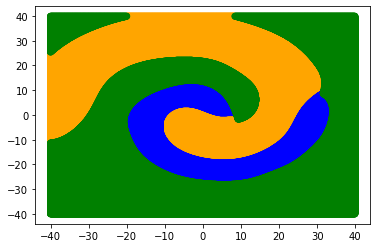

In [244]:
# Visualise activations

activation_range = np.arange(-40, 40, 0.1) # interval of [-40, 40) with step size 0.1
test_coordinates = [(x,y) for y in activation_range for x in activation_range]
test_classifications = svm_final.predict(test_coordinates)
x_, y_ = np.meshgrid(activation_range, activation_range)
plt.scatter(x_, y_, c=['b' if x_ == 0 else 'none' for x_ in test_classifications])
plt.scatter(x_, y_, c=['orange' if x_ == 1 else 'none' for x_ in test_classifications])
plt.scatter(x_, y_, c=['g' if x_ == 2 else 'none' for x_ in test_classifications])
plt.show()

In [11]:
# Compute confusion matrix for number of FP's and FN's

out_pred_test = svm_final.predict(in_test)
confusion_matrix(out_test, out_pred_test)

array([[61,  0,  0],
       [ 0, 58,  0],
       [ 0,  0, 61]], dtype=int64)